# Elo Ratings

Useful links a description of Elo rating from [World Football ELO Ratings](https://eloratings.net/about), working R example from [Robert Hickman](https://www.robert-hickman.eu/post/guardian_knowledge_june/) and the [dataset](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) he uses. Using Elo to [assess aerial performance](https://webcache.googleusercontent.com/search?q=cache:9-oen_lyqf4J:https://www.optasportspro.com/news-analysis/blog-a-new-way-to-assess-aerial-performance/+&cd=1&hl=en&ct=clnk&gl=ch). [This](https://twitter.com/petermckeever/status/1283420492289003520) series of tweets.

Every country will start with an Elo rating of 1200. The change in rating is described by the equation

$$
R_n = R_o + K\cdot G\cdot (W-W_E)\ ,
$$

where  $R_n$ is the new rating, $R_o$ is the old (previous) rating, $K$ accounts for the match importance, $G$ accounts for the strength of the result (the goal difference), $W$ is the result of the game (1 for win, 0.5 for draw and 0 for loss) and $W_E$ is the win expectancy.

$K$ is a user specified quantity which, for example, could take the values:
- 60 for World Cup Finals
- 50 for continental championship finals and major intercontinental tournaments
- 40 for World Cup and continental qualifiers and major tournaments
- 30 for all other tournaments
- 20 for friendly matches

$G$ is determined by the strength of the result and takes the values

$$
G = 
\begin{cases}
\mbox{1} & \mbox{if } N<2\ , \\ 
\mbox{1.5} & \mbox{if } N<3\ , \\
\mbox{1.75}+\frac{N-3}{8} & \mbox{if } N\geq3\ ,
\end{cases}
$$

where $N=\textrm{Goals}_i - \textrm{Goals}_j$ for team $i$ against team $j$.

Finally, we must calculate the win expectancy $W_E$ which is given by the equation

$$
W_E = \frac{1}{10^{-\frac{dr_{ij}}{400}}+1}\ ,
$$

where $dr_{ij}$ is the difference in rating between team $i$ and team $j$. The difference in rating $dr_{ij}$ can also include a home advantage factor $H$, where $dr_{ij}$ is then given by

$$
dr_{ij} = 
\begin{cases}
R_i-R_j+H & \mbox{if } i \mbox{ at home}\ , \\ 
R_i-R_j-H & \mbox{if } j \mbox{ at home}\ , \\
R_i-R_j & \mbox{if neutral}\ .
\end{cases}
$$

For this analysis I will take $H=100$ for all teams.

Before moving onto the analysis, one should keep in mind a number of things:
- How do you determine the correct $K$-factor? A larger $K$ means ratings are more sensitive to a few, recent events. A smaller $K$ would mean ratings do nnot change quickly enough to actual changes in performance level. This is also something that is likely to have changed throughout history.
- How do you determine the correct $H$-factor? Again one could look at home advantage and look at home this has changed throughout history.
- What should a teams starting rating be? When a team joins later than others, teams who play that team early on can have inflated ratings if the new teams rating is too high.

For my analysis I will focus on the ratings of international teams using the [dataset](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) mentioned above.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
df = pd.read_csv('data/international/results.csv')

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


While this dataset does specify the tournament, it does not specify the stage of the tournament. As such, I will take all matches to have $K=40$ and leave further investigation to a later study.

In [4]:
df.drop(['tournament','city','country'],axis=1,inplace=True)
df['K'] = 40

The value of G is just dependent on the scoreline.

In [5]:
def calc_G(row):
    if abs(row['home_score']-row['away_score']) < 2:
        val = 1
    elif abs(row['home_score']-row['away_score']) < 3:
        val = 1.5
    elif abs(row['home_score']-row['away_score']) >= 3:
        val = 1.75 + (abs(row['home_score']-row['away_score'])-3)/8
    return val

In [6]:
df['G'] = df.apply(calc_G,axis=1)

Finally, calculate the result.

In [7]:
def calc_result(row):
    if row['home_score'] > row['away_score']:
        result = 1.0
    elif row['home_score'] < row['away_score']:
        result = 0.0
    elif row['home_score'] == row['away_score']:
        result = 0.5
    return result

In [8]:
df['result'] = df.apply(calc_result,axis=1)

In [9]:
df.head()

,date,home_team,away_team,home_score,away_score,neutral,K,G,result
0,1872-11-30,Scotland,England,0,0,False,40,1.00,0.5
1,1873-03-08,England,Scotland,4,2,False,40,1.50,1.0
2,1874-03-07,Scotland,England,2,1,False,40,1.00,1.0
3,1875-03-06,England,Scotland,2,2,False,40,1.00,0.5
4,1876-03-04,Scotland,England,3,0,False,40,1.75,1.0


Using this dataframe I will calculate the updated Elo rating for each team after every match. I will create a new column in the dataframe showing the updated rating of the form \[new_home_team_rating, new_away_team_rating\]. 

To begin calculating the rating, the win expectancy needs to be calculated. Doing this requires specifying a value for the home advantage *H*.

In [10]:
H = 100

Initialise each team with a rating of 1200.

In [11]:
teams = np.unique(np.concatenate((df['home_team'],df['away_team'])))
team_ratings = pd.Series(1200,index=teams)

In [12]:
team_ratings = pd.melt(df, id_vars=['date'], value_vars=['home_team', 'away_team'], value_name='team').drop_duplicates(subset=['team']).sort_values(by=['date']).drop('variable',axis=1)
team_ratings['rating'] = 1200
team_ratings = team_ratings.set_index('team').drop('date',axis=1)

In [13]:
team_ratings.head()

,rating
team,
Scotland,1200
England,1200
Wales,1200
Northern Ireland,1200
United States,1200


Function to calculate Elo. In addition to returning a list of the form \[new_home_team_rating, new_away_team_rating\], it also updates the *team_ratings* dataframe, which, when applied to the full results dataframe, will make *team_ratings* the final Elo rating of each team.

In [14]:
def calc_ELO(row):
    
    hr = team_ratings.loc[row['home_team']]
    ar = team_ratings.loc[row['away_team']]
    if row['neutral'] == False:
        dr = hr - ar + H
    else:
        dr = hr - ar
    
    e_result = 1/(10**(-dr/400) + 1)
    
    new_hr = hr + (row['K'] * row['G'] * (row['result'] - e_result))
    new_ar = ar + (row['K'] * row['G'] * ((1-row['result']) - (1-e_result)))
    
    team_ratings.loc[row['home_team']] = new_hr
    team_ratings.loc[row['away_team']] = new_ar
    
    return [new_hr[0],new_ar[0]]

Calculate the Elo rating after each match in the dataframe (41586 matches).

In [15]:
# This takes a while to run
df['new_rating'] = df.apply(calc_ELO,axis=1)

In [16]:
df

,date,home_team,away_team,home_score,away_score,neutral,K,G,result,new_rating
0,1872-11-30,Scotland,England,0,0,False,40,1.00,0.5,"[1194.3974000078847, 1205.6025999921153]"
1,1873-03-08,England,Scotland,4,2,False,40,1.50,1.0,"[1226.3153770723034, 1173.6846229276966]"
2,1874-03-07,Scotland,England,2,1,False,40,1.00,1.0,"[1190.9746009192363, 1209.0253990807637]"
3,1875-03-06,England,Scotland,2,2,False,40,1.00,0.5,"[1202.479824069611, 1197.520175930389]"
4,1876-03-04,Scotland,England,3,0,False,40,1.75,1.0,"[1223.1778614597756, 1176.8221385402244]"
...,...,...,...,...,...,...,...,...,...,...
41581,2020-01-10,Barbados,Canada,1,4,True,40,1.75,0.0,"[970.8590689756546, 1433.3147011214617]"
41582,2020-01-12,Kosovo,Sweden,0,1,True,40,1.00,0.0,"[1380.3713756859802, 1610.4515195363688]"
41583,2020-01-15,Canada,Iceland,0,1,True,40,1.00,0.0,"[1413.2826290054743, 1452.7896230400183]"
41584,2020-01-19,El Salvador,Iceland,0,1,True,40,1.00,0.0,"[1361.5380327763637, 1468.508859688179]"


Teams sorted from best to worst from my Elo rating calculations.

In [17]:
team_ratings.sort_values(by='rating',ascending=False)

,rating
team,
Brazil,1870.385066
Belgium,1833.370951
Spain,1823.958371
Netherlands,1795.890052
France,1781.256512
...,...
British Virgin Islands,587.880655
Anguilla,580.151117
Northern Mariana Islands,571.368106


In [18]:
team_ratings.describe()

,rating
count,312.000000
mean,1200.000000
std,259.330952
min,498.868096
25%,1043.866014
50%,1191.820269
75%,1356.163172
max,1870.385066


Looking at the distribution of team ratings we see that they are not really normally distributed (orange line). In fact, they appear closest to a Laplace distribution (red line), which is sharpely peaked at the mean. It would be interesting to investigate how the distribution changes upon changing $K$ and $H$ values.

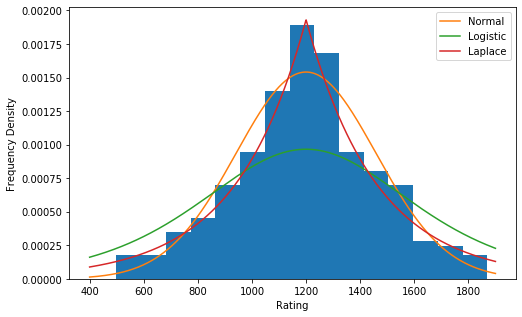

In [19]:
fig,ax = plt.subplots(figsize=(8,5))
ax.hist(team_ratings.values,bins=15,density=True)
x = np.linspace(400,1900,1000)
ax.plot(x,stats.norm.pdf(x,np.mean(team_ratings.values),np.std(team_ratings.values)),label='Normal')
ax.plot(x,stats.logistic.pdf(x,np.mean(team_ratings.values),np.std(team_ratings.values)),label='Logistic')
#ax.plot(x,stats.cauchy.pdf(x,np.mean(team_ratings.values),np.std(team_ratings.values)),label='Cauchy')
ax.plot(x,stats.laplace.pdf(x,np.mean(team_ratings.values),np.std(team_ratings.values)),label='Laplace')
ax.legend()
ax.set_ylabel('Frequency Density')
ax.set_xlabel('Rating')
plt.show()

I now want to be able to explore how teams' ratings have changed over time. To do this I create a function which, for a specified team, extracts their new rating from a match and then apply this to a dataframe of all matches played by that team. To begin, I defined the `find_ratings_over_time` function.

In [20]:
def find_ratings_over_time(row,team):
    if team == row['home_team']:
        rating = row['new_rating'][0]
    elif team == row['away_team']:
        rating = row['new_rating'][1]
    else:
        rating = None
        
    return rating

I then loop over all teams. In the loop I create a dataframe of just that team's matches and then apply the `find_ratings_over_time` function to that dataframe. I use this to produce the *ratings_over_time* dataframe which has a row for every date a match was played and then a *date* column and then a separate column for every *team*. On dates where a team doesn't play they are given a NaN value.

In [21]:
ratings_over_time = pd.DataFrame()
ratings_over_time['date'] = df['date']
for team in team_ratings.index:
    # Making a DF of just the team's matches makes this much quicker 
    # (rather than having to apply the function to every row of 41586 for every team)
    df_team = pd.concat([df[df['home_team'] == team],df[df['away_team'] == team]]).sort_index()
    ratings = df_team.apply(find_ratings_over_time,args=(team,),axis=1)
    ratings.rename(team,inplace=True)
    ratings_over_time = pd.concat([ratings_over_time,ratings],axis=1)

In [22]:
ratings_over_time

,date,Scotland,England,Wales,Northern Ireland,United States,Uruguay,Austria,Hungary,Argentina,...,Surrey,Panjab,Matabeleland,Cascadia,Kabylia,Timor-Leste,Myanmar,Parishes of Jersey,Chameria,Saint Helena
0,1872-11-30,1194.397400,1205.602600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1873-03-08,1173.684623,1226.315377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1874-03-07,1190.974601,1209.025399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1875-03-06,1197.520176,1202.479824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1876-03-04,1223.177861,1176.822139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41581,2020-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41582,2020-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41583,2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41584,2020-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using this data I can now plot how the ratings of teams has changed over time. Here I use the example of the current top 5 teams and see how their ratings have changed since 1980.

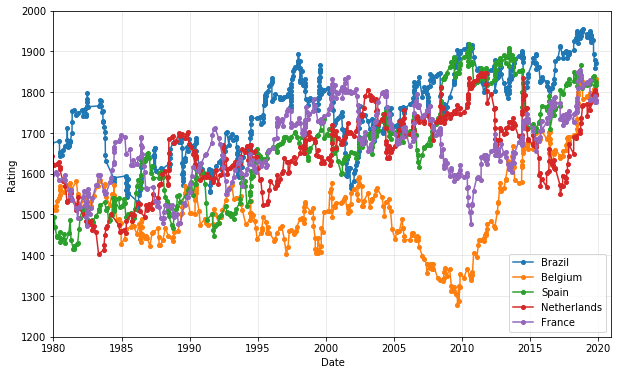

In [23]:
fig,ax = plt.subplots(figsize=(10,6))
top5 = team_ratings.sort_values(by='rating',ascending=False).index[0:5]
for team in top5:
    df_temp = ratings_over_time[['date',team]].dropna()
    ax.plot(pd.to_datetime(df_temp['date']),df_temp[team],'-o',ms=4,label=team)
ax.legend()
ax.set_xlim([dt.datetime(1980,1,1),dt.datetime(2021,1,1)])
ax.set_ylim([1200,2000])
ax.set_xlabel('Date')
ax.set_ylabel('Rating')
ax.grid(alpha=0.3)
plt.show()